# Time Series Model: D213 Advanced Data Analytics Task 1
## Project by Natalie Toler
-----

## Contents
### Part 1: Research Question
    - A1. Research Question
    - A2. Goals of Analysis
### Part 2: Method Justification
    - B. Assumptions of Time Series Models
### Part 3: Data Preparation
    - C1. Line Graph Visualization
    - C2. Time Step Formatting
    - C3. Stationarity
    - C4. Data Preparation
    - C5. Cleaned Data set
### Part 4: Model Identification and Analysis
    - D1. Report Findings
    - D2. Autoregressive Integrated Moving Average Model
    - D3. Forcast
    - D4. Analysis Output
    - D5. Code
### Part 5: Data Summary and Implications
    - E1. Results of Analysis
    - E2. Annotated Visuals
    - E3. Course of Action
### Part 6: Reporting

### Sources

## Part One: Research Question

A1. Is it possible to correctly forecast the daily revenues of the WGU Hospital System effectively and accurately?

A2. The goal is to determine if daily revenues can be predicted with an ARIMA time series model using the provided data set so that organizational leadership can strategize to maintain revenue at levels that allows the hospital to continue serving patients. The model will be a supervised learning model with data split into training and test groups instead of forcasting into the unknown future. 

## Part Two: Method Justification

B. There are several assumptions of the data that are used to effectively create an ARIMA model. 

- The Time Series data should be stationary, or the distribution of the observations do not depend on time.
- The data should contain no outliers. Outliers or anamolies in the data will skew the model.
- The data is univariate, meaning there is only a single variable.
- Past datapoints are indicative of future datapoints. Which means that the relationship between the variable and time, in this case revenue and the days, stays consistent and will not change drastically in the future.

## Part Three: Data Preparation

#### C1. Time Series Visualization

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load data set
df = pd. read_csv('medical_time_series .csv')
# Check size and values of the Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [2]:
# Inspect dataframe visually

pd.set_option('display.max_columns', None)
df

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


The dataset provided represents the revenue of the hospital for the first two years of operation. The day column represents each day in the first two years. In order to perform the time series analysis the day needs to be converted into a datetime format. In order to do this, since there is no further guidance in the rubric, I will pick a random day to start. Often when working with hospital data it is important to not use 2020, 2021, and even 2022 as years of standard analysis since the Covid-19 Pandemic skews all hospitalization data. Therefore it would make sense to pick 2018-2019. I will therefore choose 01/01/2018 as the start date for the time series analysis. 

In [3]:
# Convert the day column to datetime format by using timedelta
start_date = pd.to_datetime('2018-01-01')
df['Day'] = start_date + pd.to_timedelta(df['Day'] - 1, unit='D')

# Rename columns
df.columns = ['date', 'revenue']

# Set date column as the index
df.set_index('date', inplace = True)

df

,revenue
date,
2018-01-01,0.000000
2018-01-02,-0.292356
2018-01-03,-0.327772
2018-01-04,-0.339987
2018-01-05,-0.124888
...,...
2019-12-28,15.722056
2019-12-29,15.865822
2019-12-30,15.708988


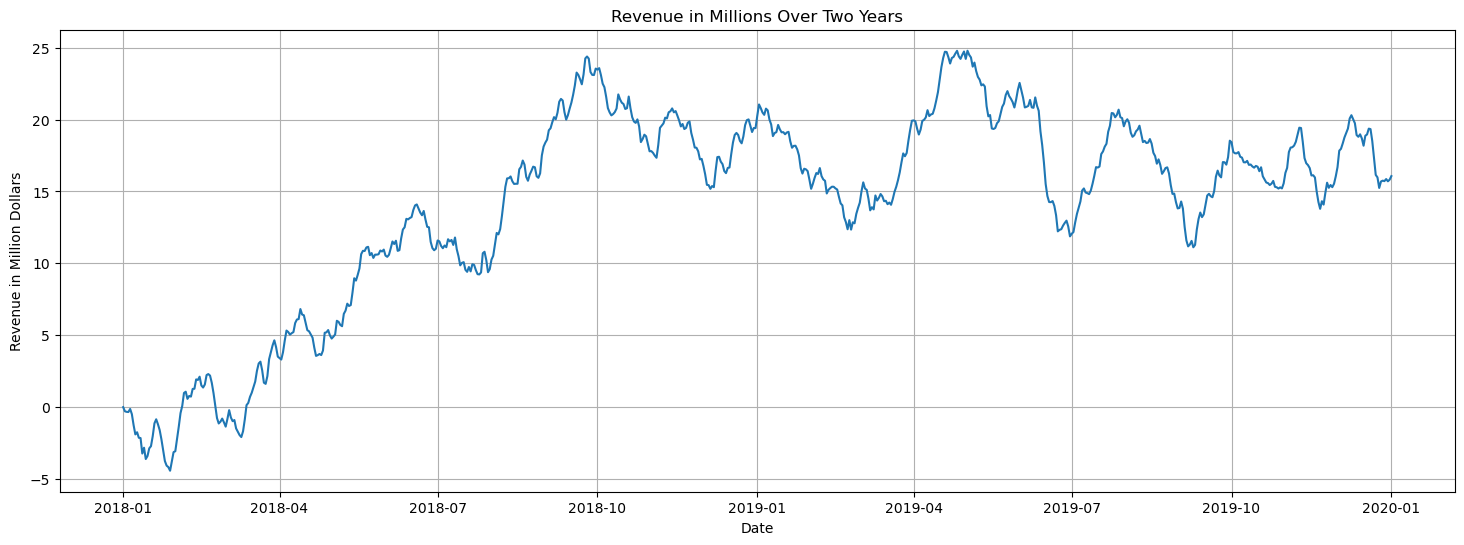

In [4]:
# Plot the data
plt.figure(figsize = (18, 6))
plt.plot(df.revenue)
plt.title('Revenue in Millions Over Two Years')
plt.xlabel('Date')
plt.ylabel('Revenue in Million Dollars')
plt.grid(True)
plt.show()

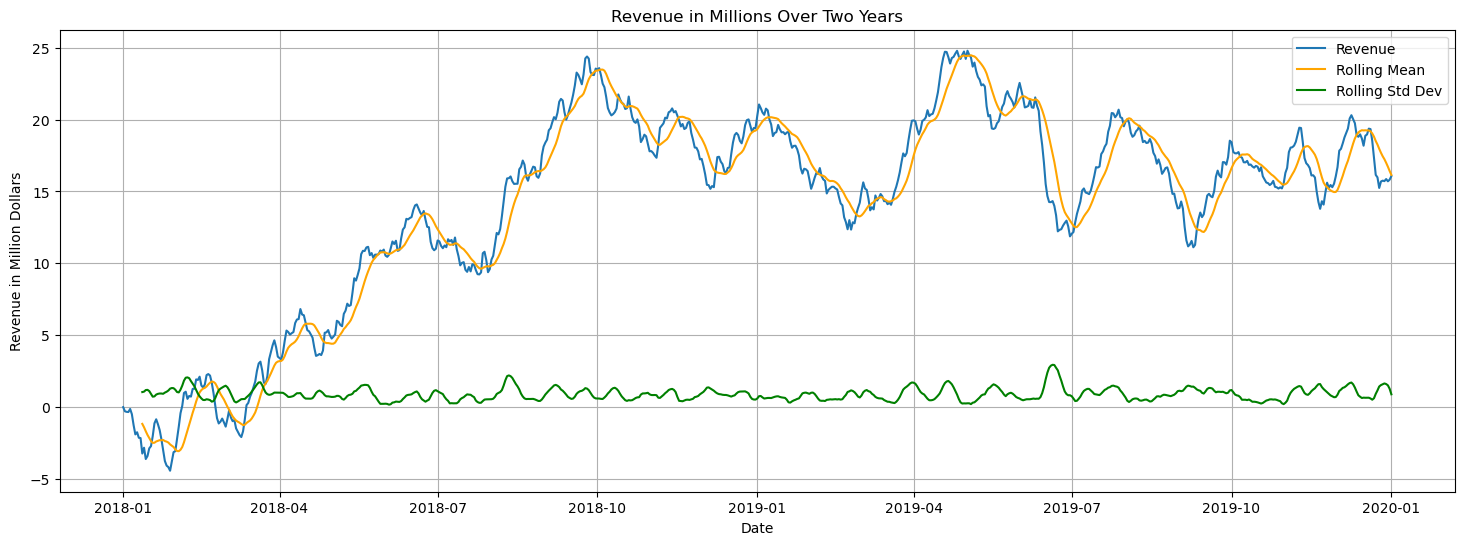

In [5]:
# Calculate rolling mean and rolling standard deviation for finding Stationarity
rolling_mean = df['revenue'].rolling(window=12).mean()
rolling_std = df['revenue'].rolling(window=12).std()

# Plot the time series, rolling mean, and rolling standard deviation
plt.figure(figsize=(18, 6))
plt.plot(df['revenue'], label='Revenue')
plt.plot(rolling_mean, color='orange', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std Dev')
plt.title('Revenue in Millions Over Two Years')
plt.xlabel('Date')
plt.ylabel('Revenue in Million Dollars')
plt.legend()
plt.grid(True)
plt.show()

We can see that there is an upward trend in revenue overall as well as fluctuations with several peaks and troughs which could relate to seasonal trends. The relatively flat and low rolling standard deviation indicates that the dispersion around the mean is not high even though there are significant fluctuations in revenue over the two year period. The overall trend of the rolling mean indicates that there is a general increase in revenue over the two year period. 

#### C2. Time Step Formatting

There are no gaps in the dataset. The time step is a day and there are 731 days recorded. This is two years with each day correlating to a unique day with no absent data.

#### C3. Stationarity

To evaluate the stationarity of this dataset I will use the augmented Dickey-Fuller (ADFuller) test. The Null Hypothesis for this test is "The time series has a unit root, meaning it is non-stationary" and the alternative hypothesis is "the time series does not have a unit root, meaning it is stationary." 

In [6]:
# Perform Augmented Dickey-Fuller test
result = adfuller(df['revenue'])

# Print the test statistics
print('Test Statistic: ', result[0])
print('P-value: ', result[1])
print('Critical Values: ', result[4])

# Check if the p-value is less than or equal to 0.05
if result[1] <= 0.05:
    print('Reject null hypothesis, time series is stationary')
else:
    print('Fail to reject null hypothesis, time series is non-stationary')

Test Statistic:  -2.218319047608944
P-value:  0.1996640061506439
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Fail to reject null hypothesis, time series is non-stationary


Here we have a P-value of 0.2 This is greater than the threshold of significance therefore we fail to reject the null-hypothesis. Therefore the time series is non-stationary. 

#### C4. Data Preparation

Test Statistic:  -17.37477230355706
P-value:  5.1132069788403175e-30
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


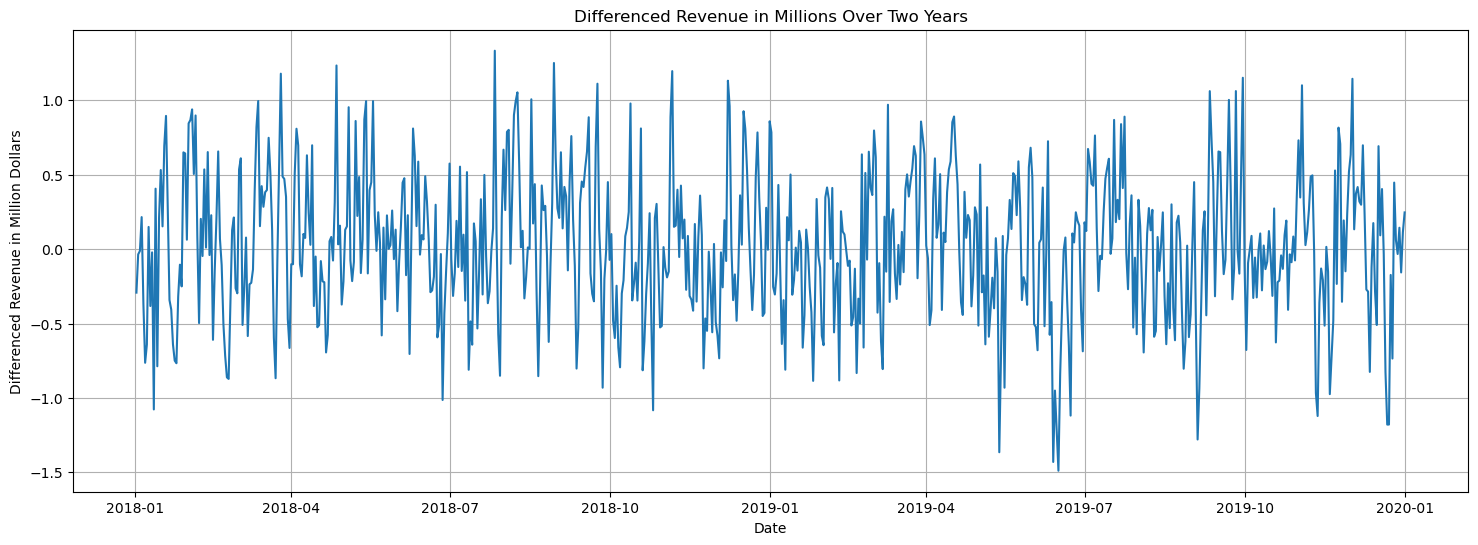

In [7]:
# Difference the data to make it stationary
df_diff = df.diff().dropna()

# Perform Augmented Dickey-Fuller test on differenced data
diff_result = adfuller(df_diff['revenue'])
print('Test Statistic: ', diff_result[0])
print('P-value: ', diff_result[1])
print('Critical Values: ', diff_result[4])

# Plot the differenced data
plt.figure(figsize=(18, 6))
plt.plot(df_diff['revenue'])
plt.title('Differenced Revenue in Millions Over Two Years')
plt.xlabel('Date')
plt.ylabel('Differenced Revenue in Million Dollars')
plt.grid(True)
plt.show()

Interpretation of Results:

Test Statistic: -17.37477230355706
- This value is much lower than the critical values at the 1%, 5%, and 10% levels.

P-value: 5.1132069788403175e-30
- This is a low p-value, significantly below the 0.05 threshold.

Since the test statistic is less than the critical values for all significance levels and the p-value is much less than 0.05, I can now reject the null hypothesis that the time series has a unit root. This indicates that the differenced data is stationary.

In [8]:
# Calculate the split index
split_index = int(len(df_diff) * 0.8)

# Split the data into training and testing sets
train = df_diff[:split_index]
test = df_diff[split_index:]

print(train.shape, test.shape)

(584, 1) (146, 1)


#### C5. Prepared Datasets

In [9]:
train.to_csv('task1_train_clean.csv')
test.to_csv('task1_test_clean.csv')

## Part Four: Model Identification and Analysis

#### D1. Report Findings

    - Seasonality

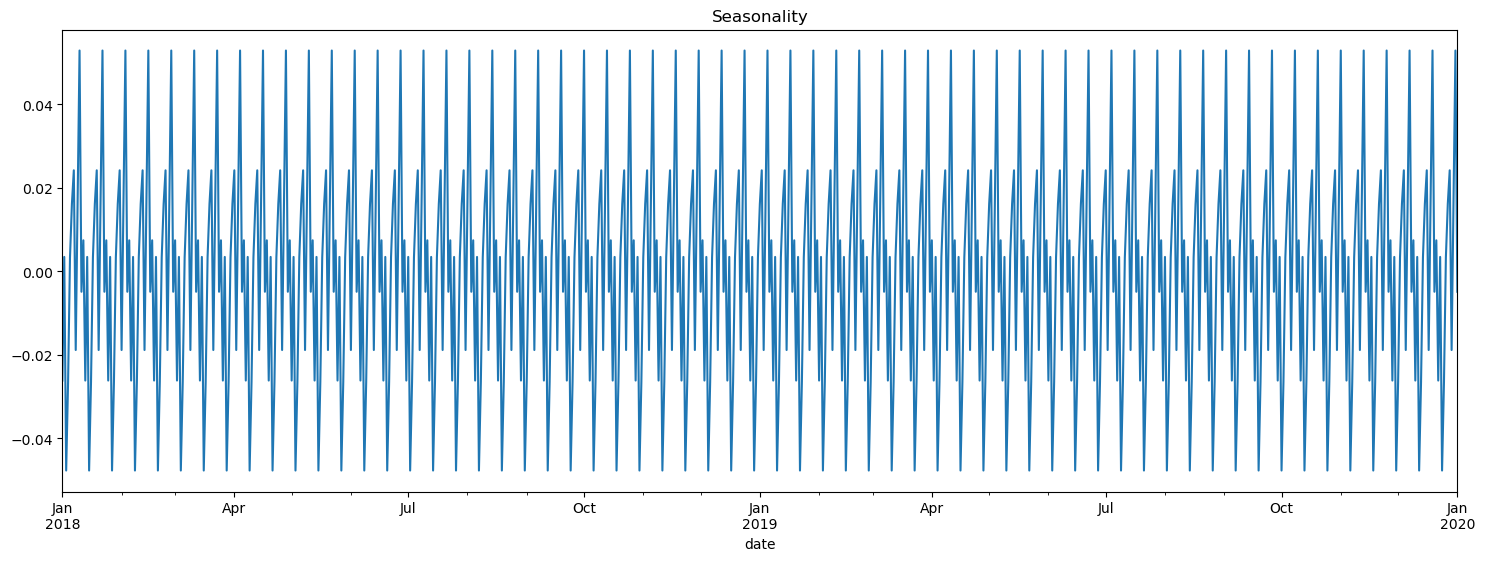

In [10]:
# Perform seasonal decomposition
decomp = seasonal_decompose(df['revenue'], model='additive', period=12)

# Plot the seasonality component
plt.figure(figsize=(18, 6))
plt.title('Seasonality')
decomp.seasonal.plot()
plt.show()

The graph shows a clear repetitive pattern in the decomposed data, indicating that there is a strong seasonal effect in the revenue data. Each cycle appears to be quite consistent, suggesting that seasonality is stable over time. The magnitude of the seasonal component is quite small, 0.04 in each direction. The period of time that each fluctuation happens in is also quite short which suggests seasonality in the scope of a week opposed to months. 

    - Trends

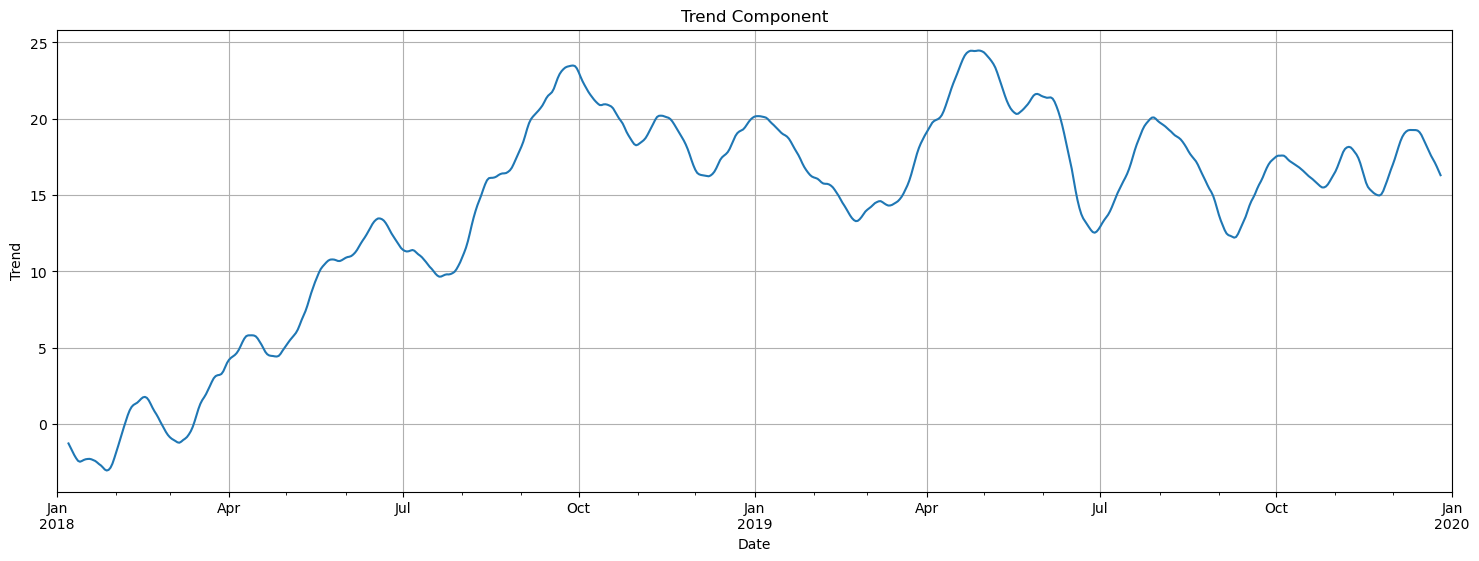

In [11]:
# Plot the trend component
plt.figure(figsize=(18, 6))
plt.title('Trend Component')
decomp.trend.plot()
plt.xlabel('Date')
plt.ylabel('Trend')
plt.grid(True)
plt.show()

Here we can see the trend over the two years. There is an initial clear growth in the first part of the period, between January 2018 and October 2018. For the rest of the period the growth isn't as large. The peak is around May 2019 which is followed by a decline in revenue. The revenue becomes more stable at the end of our time period, with general stability between October 2019 to December 2019. Overall the long-term movement is upward.

    - Auto Correlation Function

In [12]:
stepwise_fit = auto_arima(df['revenue'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.18 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.111 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Tue, 30 Jul 2024   AIC                            879.982
Time:                        14:58:54   BIC                            889.168
Sample:                    01-01-2018   HQIC                           883.526
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From this auto-arima we can see that the best model is ARIMA(1,1,0). This has an AIC of 879.982 which is the lowest of all the tested models, indicating the best fit.

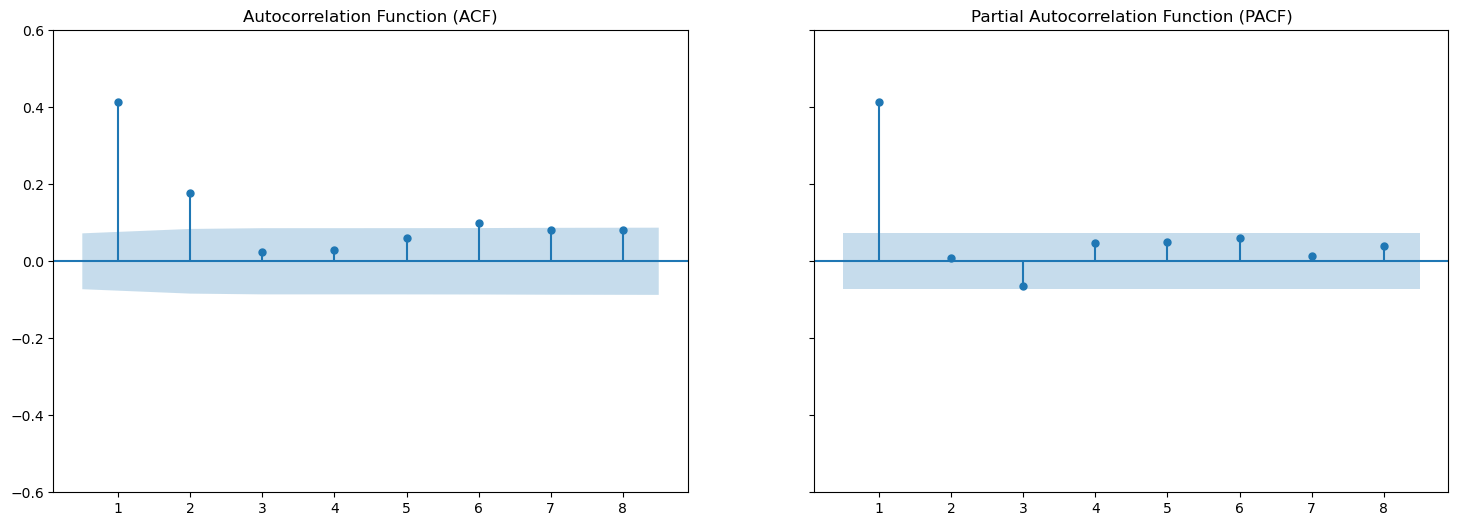

In [13]:
# Set up visualization space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot ACF to 8 lags (seven days in a week), ignoring zero lag
plot_acf(df_diff['revenue'], lags=8, zero=False, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF to 8 lags, ignoring zero lag
plot_pacf(df_diff['revenue'], lags=8, zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.ylim(-0.6, 0.6)
plt.show()

The ACF and PACF are used to determine whether a model is autoregressive (AR) or moving average (MA). In this case, the ACF chart tails off around lag 2, and the PACF cuts off sharply at lag 1. This behavior suggests that an AR(1) model is best suited for this dataset.

    - Spectral Density

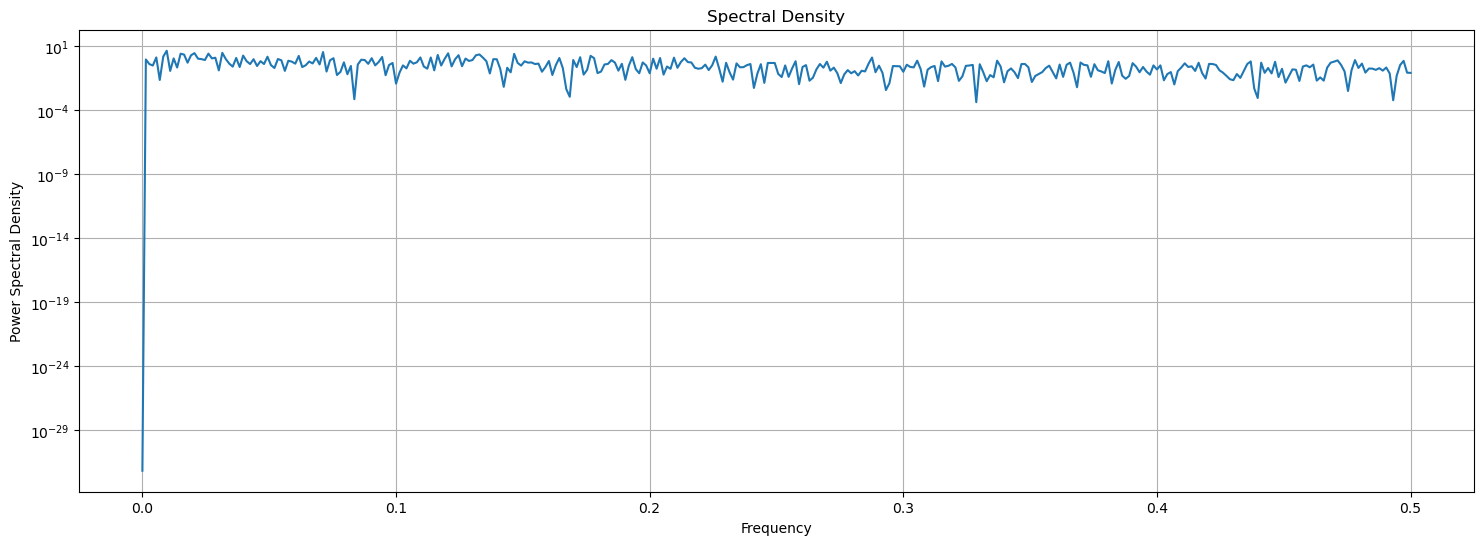

In [14]:
# Compute the periodogram
frequencies, power_density = periodogram(df_diff['revenue'])

# Plot the spectral density
plt.figure(figsize=(18, 6))
plt.semilogy(frequencies, power_density)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

This shows the spectral density analysis of the dataset. The spikes seem to be random which shows no seasonality or periodicity. 

    - Decomposed Time Series

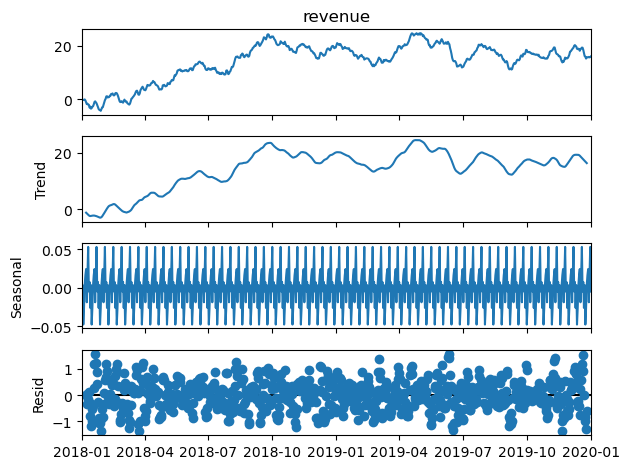

In [15]:
decomp.plot();

Decomposing the time series as done here seperates out the data into three components, trend, seasonality, and residual. This allows us to identify that the data has these three components. 

    - Confirmation of the lack of trends in the residuals of the decomposed series

<Axes: title={'center': 'Residuals'}, xlabel='date'>

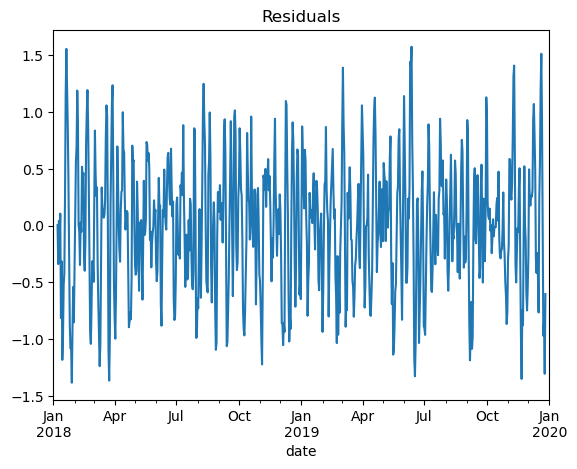

In [16]:
plt.title('Residuals')
decomp.resid.plot()

The residuals show small deviation and variation from the residual line which indicates that there is no seasonality. 

#### D2. Autoregressive Integrated Moving Average Model

In combination with Auto-ARIMA finding (1, 1, 0) to be the best fit and the ACF/PACF showing AR(1) as the best suit I will set up my ARIMA model with (1,1,0).

In [17]:
# Set up the frequency parameter in the train data
train.index = pd.to_datetime(train.index)
train = train.asfreq('D')

# Fit the ARIMA model
model = ARIMA(train['revenue'], order=(1, 1, 0))
results = model.fit()

# Print the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -421.036
Date:                Tue, 30 Jul 2024   AIC                            846.071
Time:                        14:58:57   BIC                            854.808
Sample:                    01-02-2018   HQIC                           849.476
                         - 08-08-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3185      0.040     -8.010      0.000      -0.396      -0.241
sigma2         0.2482      0.017     14.964      0.000       0.216       0.281
Ljung-Box (L1) (Q):                   1.23   Jarque-

#### D3. Forecast

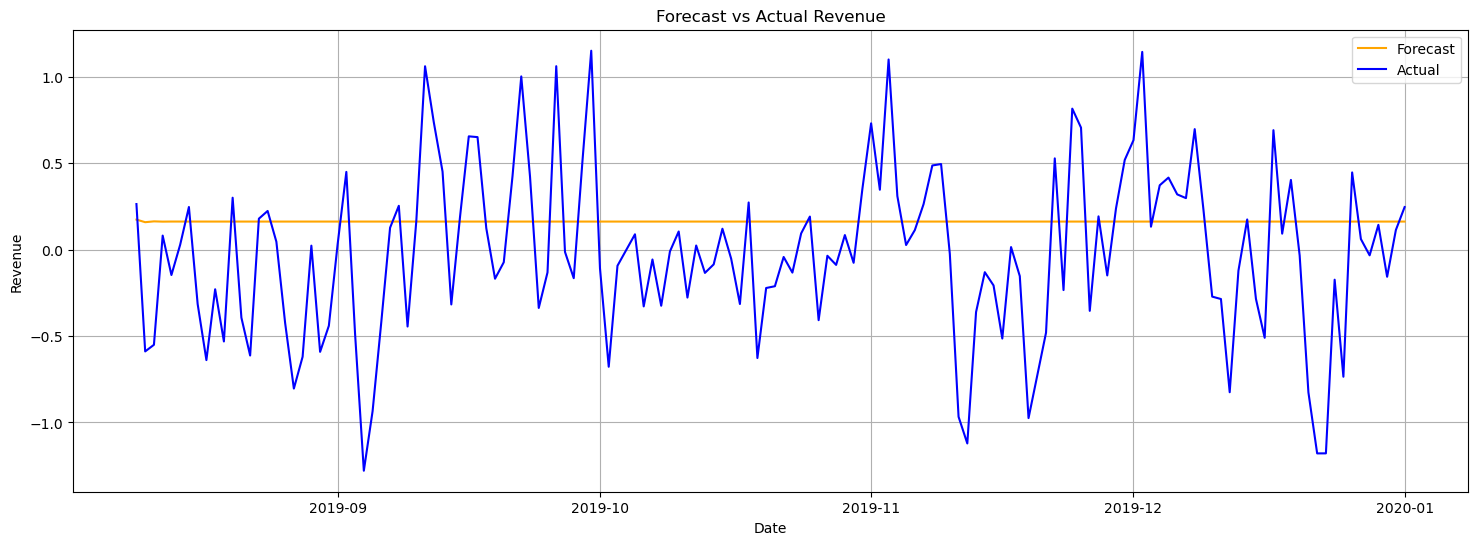

In [19]:
# Forecast on test
start = len(train)
end = start + len(test) - 1

# Use get_forecast
forecast_test = results.get_forecast(steps=len(test))
forecast_test_mean = forecast_test.predicted_mean

# Set the index of the prediction series to match the test set
forecast_test_mean.index = test.index

# Plot the predictions and the actual values from the test set
plt.figure(figsize=(18, 6))
plt.plot(forecast_test_mean, label='Forecast', color='orange')
plt.plot(test['revenue'], label='Actual', color='blue')
plt.title('Forecast vs Actual Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Predict the next 3 months
# Determine the start date for the forecast
start_date = test.index[-1] + pd.Timedelta(days=1)
# Create the date index for 3 months of daily predictions
index_future_dates = pd.date_range(start=start_date, periods=90)

# Use get_forecast to predict the next 3 months
forecast_next_3_months = results.get_forecast(steps=90)
mean_prediction = forecast_next_3_months.predicted_mean
confidence_intervals = forecast_next_3_months.conf_int()
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

# Set the index of the prediction series to match the future dates
mean_prediction.index = index_future_dates
lower_limits.index = index_future_dates
upper_limits.index = index_future_dates

print(mean_prediction)

2020-01-02    0.174172
2020-01-03    0.159033
2020-01-04    0.163855
2020-01-05    0.162320
2020-01-06    0.162809
                ...   
2020-03-27    0.162691
2020-03-28    0.162691
2020-03-29    0.162691
2020-03-30    0.162691
2020-03-31    0.162691
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


Here we can see that there is fluctuation of revenue in the beginning but by the end of the forecasted time the model forecasts that revenue will stay steady.

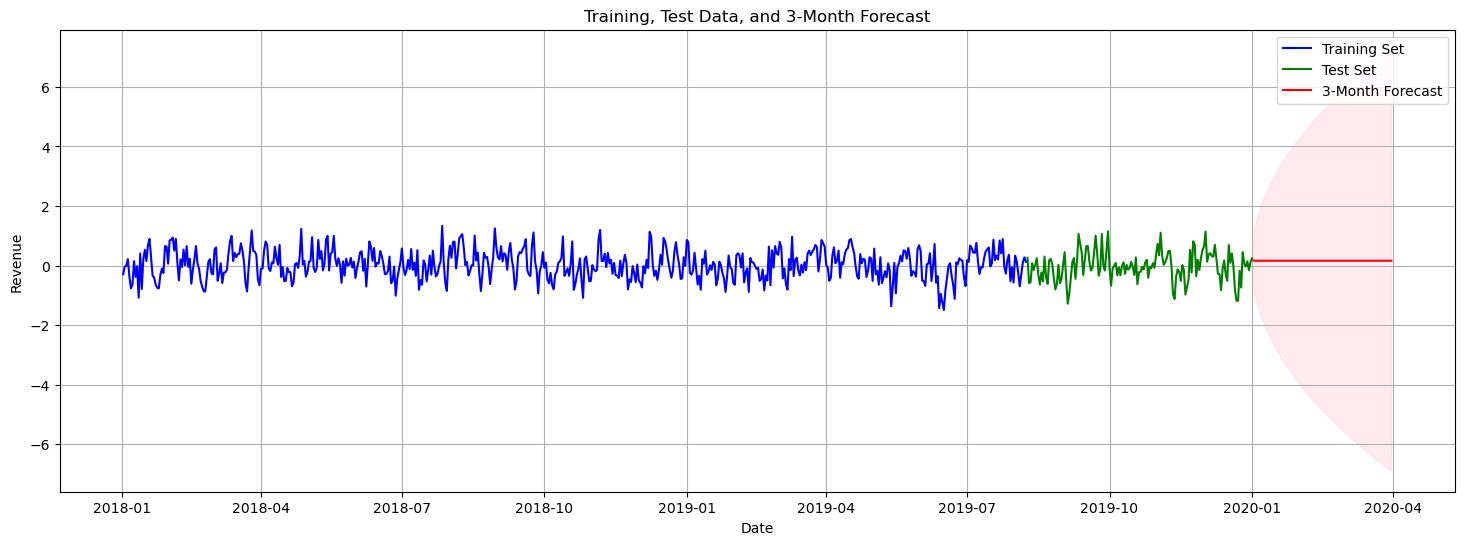

In [21]:
# Plot the Entire dataset with the 3-month forecast
plt.figure(figsize=(18, 6))
plt.plot(train.index, train['revenue'], label='Training Set', color='blue')
plt.plot(test.index, test['revenue'], label='Test Set', color='green')
plt.plot(mean_prediction.index, mean_prediction, color='red', label='3-Month Forecast')
plt.fill_between(mean_prediction.index, lower_limits, upper_limits, color='pink', alpha=0.3)
plt.title('Training, Test Data, and 3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

#### D4. Analysis Output

In [22]:
# Perform a root mean square error and diagnostic plots for evaluation of the model
# Calculate the RMSE
actual_values = test['revenue']
errors = forecast_test_mean - actual_values
rmse = np.sqrt(mean_squared_error(actual_values, forecast_test_mean))

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Root Mean Squared Error (RMSE): 0.5195


<Figure size 1600x1200 with 0 Axes>

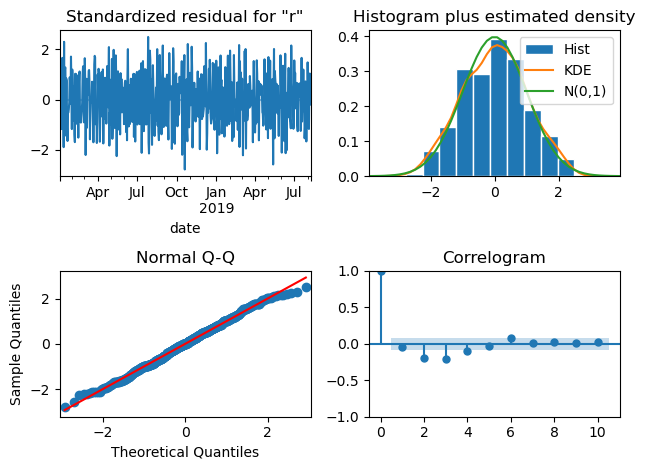

In [23]:
# Set figure size
plt.figure(figsize=[16, 12])

# Plot diagnostics
results.plot_diagnostics()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show();

#### D4 & D5.

The code output for all of the project is above, including all output needed to satisfy parts D4 and D5 of the rubric.

## Part Five: Data Summary and Implications

#### E1. Results of Analysis

    - Selection of ARIMA model
    
As shown above the model was selected using three different means. The first was the Auto-ARIMA which cycled through a series of different Ar and MA combinations to find the model with the lowest AIC score. The result was that the model (1, 1, 0) was the lowest AIC score with 879.982. To confirm this the ACF and PACF showed that an AR(1) model would indeed be best fit. This interpretation of the ACF and PACF come from the Datacamp course. [Time Series Analysis in Python](https://app.datacamp.com/learn/courses/time-series-analysis-in-python)
    
    The code and output for these three tests are provided again below.

In [24]:
# Set up Auto arima
stepwise_fit = auto_arima(df['revenue'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.992 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Tue, 30 Jul 2024   AIC                            879.982
Time:                        14:59:36   BIC                            889.168
Sample:                    01-01-2018   HQIC                           883.526
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

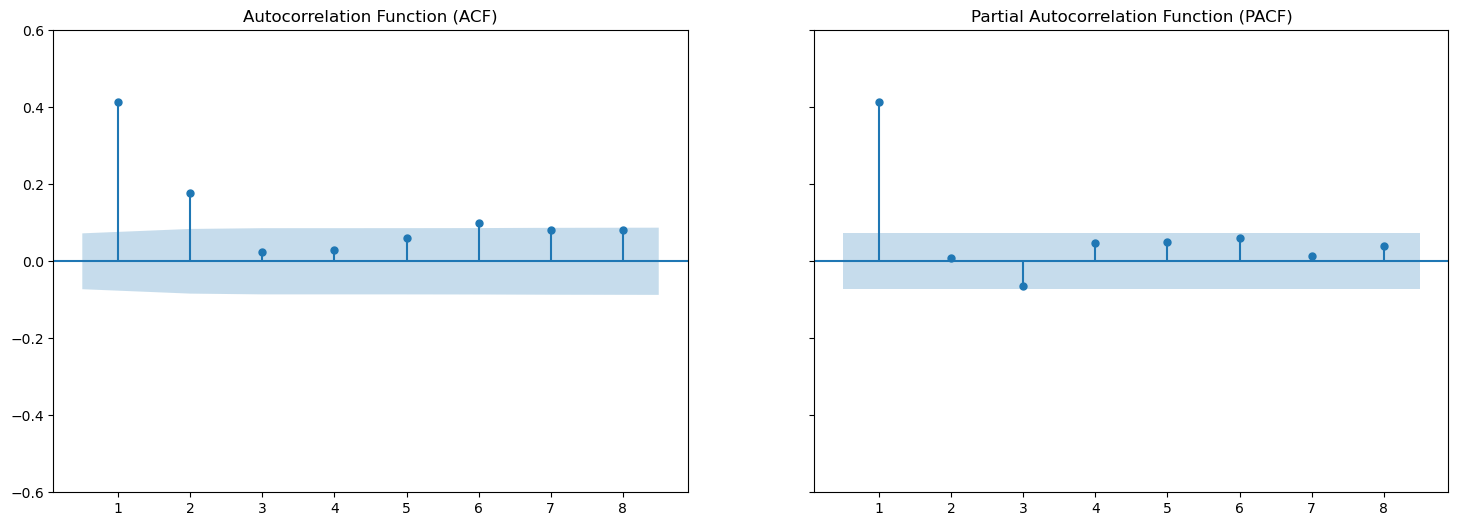

In [25]:
# Set up visualization space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot ACF to 8 lags (seven days in a week), ignoring zero lag
plot_acf(df_diff['revenue'], lags=8, zero=False, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF to 8 lags, ignoring zero lag
plot_pacf(df_diff['revenue'], lags=8, zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.ylim(-0.6, 0.6)
plt.show()

    - Prediction interval of the Forecast
    
The prediction interval for the forecast represents the range within which future values are expected to fall with a certain level of confidence. In this time series the data is daily revenue over a two year span. The ARIMA model, therefore, uses the historical correlations and patterns to forecast the future revenue at daily intervals. 
    
    - Justification of the forecast length
    
Given that the dataset consists of two years of daily revenue data, forecasting beyong the a year would be unreliable due to the limited historical data available. Forecasting longer periods requires more extensive historical datasets to ensure accuracy and capture longer-term trends and seasonality. Since a longer forecast would lead to more instability in the model I chose 3 months as the length of my prediction. 
    
    - Model Evaluation procedure and error metric
    
The model is evaluated in two ways. The first is the model's forecast relative to other models by using the root mean squared error. For this model the RMSE is 0.5195. A low RMSE indicates a better fit of the model to the data, however whether the RMSE of 0.5195 is a good fit would need to be compared to other models or historical benchmarks. On its own what the RMSE tells us is that, on average, the forecasted values deviate from the actual values by approximately 0.5195 units (in this case millions of dollars). 
    
The second model evaluation method involves using diagnostic_plots(), which generates a series of plots to visualize the performance of the ARIMA model. These plots help in evaluating the model's residuals and overall fit.
    
I have reproduced the `diagnostic_plots()` below.

<Figure size 1600x1200 with 0 Axes>

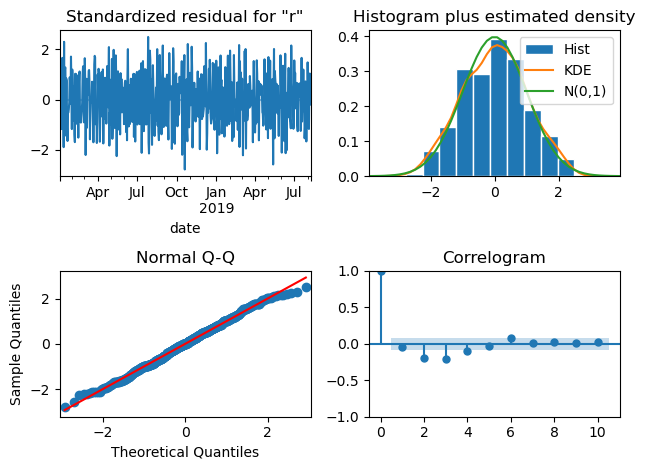

In [26]:
# Set figure size
plt.figure(figsize=[16, 12])

# Plot diagnostics
results.plot_diagnostics()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show();

From top left going clockwise the visualizations are:

- The Standardized residual: Assesses if residuals exhibit any patterns. This plot should show no apparent patterns, which indicates that the residuals are randomly distributed. We can see that this model indeed shows no significant patterns.
- The histogram with estimated density (KDE). The kernel density estimate (KDE) curve should approximate a normal distribution. This is the case with this model which suggests that the residuals are normally distributed.
- The normal Q-Q plot compared the distribution of residuals to a normal distribution. Here we want to see most, if not all, of the datapoints (the blue) on the red line. This is the case for most of the line but the end of our data points fall off the red line which might suggest slight deviations from normality.
- The Correlogram which examines the autocorrelation of residuals at different lags. Correlations at lags greater than one should, ideally, be insignificant, meaning they fall within the shaded area. For this model, lags 2 and 3 are outside of the shaded area, indicating significant correlations, while lag 6 is near the border of significance. 

The standardized residual plot, histogram with KDE, and normal Q-Q plot all indicate that the model is a good fit. However there are significant autocorrelations at certain lags shown in the correlogram which suggests that the model may not full capture all correlations. Overall, the residual diagnostics suggest the model is reasonably well-fitted with room for further model improvement.

#### E2. Annotated Visuals

I have reproduced the final model compared to test set visualization that was created above here.

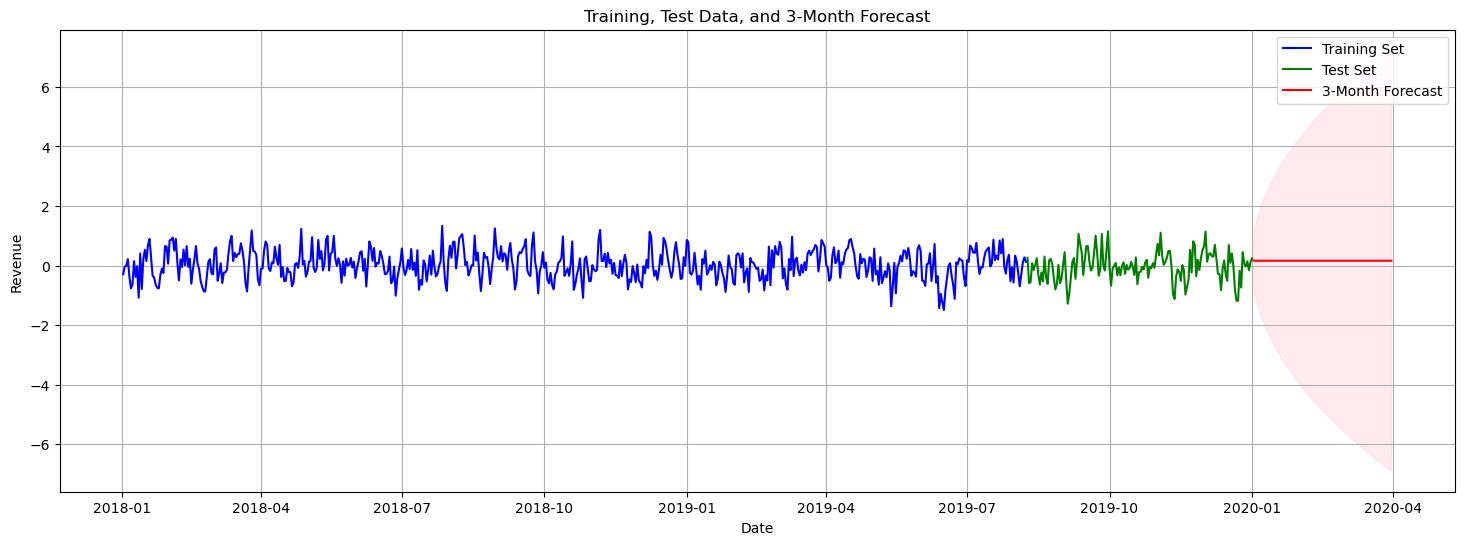

In [27]:
# Plot the Entire dataset with the forecasted 3-months
plt.figure(figsize=(18, 6))
plt.plot(train.index, train['revenue'], label='Training Set', color='blue')
plt.plot(test.index, test['revenue'], label='Test Set', color='green')
plt.plot(mean_prediction.index, mean_prediction, color='red', label='3-Month Forecast')
plt.fill_between(mean_prediction.index, lower_limits, upper_limits, color='pink', alpha=0.3)
plt.title('Training, Test Data, and 3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

The model forecasts steady revenue with no increase or decrease. This model is technically successful in that the forecast does not deviate greatly from the observed test set. Therefore we can conclude that this model can, to some degree of accuracy, forecast daily revenue. 

#### E3. Course of Action

To answer the research question, it is possible to forecast hosptial revenue using the ARIMA model. The ARIMA model was able to perform a forecast with daily revenue prediction for a period of 90 days. However the model does smooth out the ups and downs of the actually daily revenue when the forecast is compared to the test set and therefore should not be used for revenue projection over the short term. The most actionable insight that this model brings is that the hospital revenue has stagnated and this model can be used to show that stagnation and perhaps work towards either increasing daily revenue if needed or maintaining revenue if it is suffecient. 

Longer forecasts can be done with longer revenue data and therefore it would be predent for the hospital to continue to store revenue data for future use.

## Part Six: Reporting

This report has been created using Juptyer Notebook and includes all required code and analysis.

## Sources

This project was created using the datacamp courses for D213 and the course webinars and powerpoints. 

Reider, R. (n.d.). *Time series analysis in Python*. DataCamp. Retrieved July 23, 2024, from https://app.datacamp.com/learn/courses/time-series-analysis-in-python

Elleh, Dr. Festus (n.d.). *D213 Task 1 Data Preprocessing in Python*. Western Governors University. Retrieved July 23, 2024, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=8d32afc8-d66f-42d5-9117-b100016cf9ac

Elleh, Dr. Festus (n.d.). *D213 Task 1 Building ARIMA model in Python*. Western Governors University. Retrieved July 23, 2024, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1aaf2389-6483-4000-b498-b14f00441d57

Sewell, Dr. William (n.d.). *Time Series Analysis, webinar 1*. Western Governorts University. Retrieved July 23, 2024, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=358071e7-9c01-4274-a044-af7400ec1c40


Sewell, Dr. William (n.d.). *Time Series Analysis, webinar 2*. Western Governorts University. Retrieved July 23, 2024, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=37007075-c29e-43f2-a106-af7800d45914